In [3]:
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# import data using pandas
import pandas as pd

df = pd.read_csv('../data/FINAL_cleaning_data.csv')
df.head()

,Time,Replicates,Surface,Cleaning,Count
0,-48.0,1,Stainless Steel,NIL,6016.0
1,-48.0,2,Stainless Steel,NIL,5767.0
2,-48.0,3,Stainless Steel,NIL,5500.0
3,-48.0,4,Stainless Steel,NIL,6700.0
4,-41.0,1,Stainless Steel,NIL,1075.0


## Plot logistic growth of NIL data



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


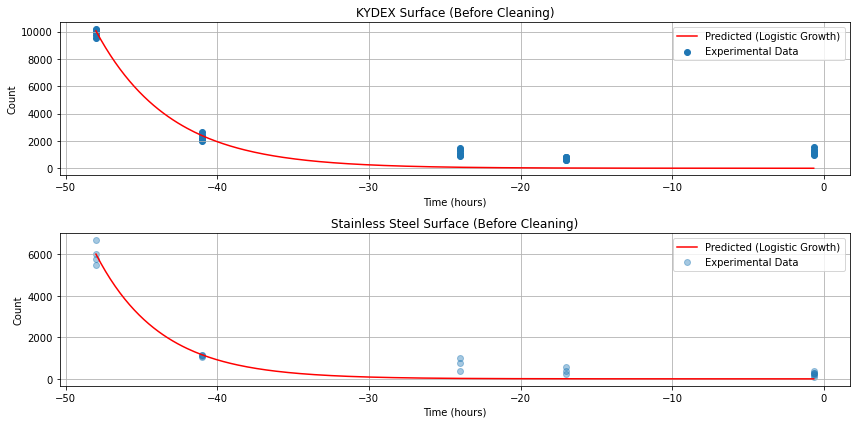

In [12]:
# Define the logistic growth model
def logistic_growth_model(y, t, r, K):
    C = y
    dCdt = r * C * (1 - C / K)
    return dCdt

# Function to predict using the logistic growth model
def predict_logistic_growth(t, r, K, C0):
    solution = odeint(logistic_growth_model, C0, t, args=(r, K))
    return solution.ravel()

# Function to fit the logistic growth model to the data
def fit_logistic_growth(subgroup_data):
    # Define the function to fit the data
    def fit_func(t, r, K):
        y0 = subgroup_data['Count'].iloc[0]
        solution = odeint(logistic_growth_model, y0, t, args=(r, K))
        return solution.ravel()

    # Extract time and count data
    t_data = subgroup_data['Time'].values
    count_data = subgroup_data['Count'].values

    # Provide initial guesses for the parameters
    initial_guesses = (0.1, max(count_data))

    # Fit the ODE to the data using curve_fit
    popt, _ = curve_fit(fit_func, t_data, count_data, p0=initial_guesses)
    return popt

# data_before_cleaning: data before cleaning from df, only NIL data
data_before_cleaning = df[df['Cleaning'] == 'NIL']


# Replace NAN values with the mean of the data at that time point. Add Gaussian noise to the at that time point only.
for i in range(len(data_before_cleaning)):
    if np.isnan(data_before_cleaning['Count'].iloc[i]):
        data_before_cleaning['Count'].iloc[i] = np.random.normal(data_before_cleaning['Count'].iloc[i - 1], 200)

# Get the NIL data for each surface type
nil_data_kydex = data_before_cleaning[(data_before_cleaning['Surface'] == 'KYDEX') & (data_before_cleaning['Cleaning'] == 'NIL')]
nil_data_stainless_steel = data_before_cleaning[(data_before_cleaning['Surface'] == 'Stainless Steel') & (data_before_cleaning['Cleaning'] == 'NIL')]

# Fit the logistic growth model to the NIL data for each surface type
parameters_kydex = fit_logistic_growth(nil_data_kydex)
parameters_stainless_steel = fit_logistic_growth(nil_data_stainless_steel)

# Parameters for KYDEX and Stainless Steel surfaces
parameters_kydex, parameters_stainless_steel

# Time points for prediction
t_pred = np.linspace(nil_data_kydex['Time'].min(), nil_data_kydex['Time'].max(), 300)

# Predicted counts for KYDEX using logistic growth model
predicted_counts_kydex = predict_logistic_growth(t_pred, *parameters_kydex, nil_data_kydex['Count'].iloc[0])

# Predicted counts for Stainless Steel using logistic growth model
predicted_counts_stainless_steel = predict_logistic_growth(t_pred, *parameters_stainless_steel, nil_data_stainless_steel['Count'].iloc[0])

# Plot the experimental vs. predicted data for KYDEX
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.scatter(nil_data_kydex['Time'], nil_data_kydex['Count'], label='Experimental Data')
plt.plot(t_pred, predicted_counts_kydex, color='red', label='Predicted (Logistic Growth)')
plt.xlabel('Time (hours)')
plt.ylabel('Count')
plt.title('KYDEX Surface (Before Cleaning)')
plt.legend()
plt.grid(True)

# Plot the experimental vs. predicted data for Stainless Steel
plt.subplot(2, 1, 2)
#plot errorbars of nil_data_stainless_steel for each time point. Calculate the mean and std of each time point first
data=nil_data_stainless_steel.groupby('Time').agg({'Count': ['mean', 'std']}).reset_index().plot(x='Time', y='Count', yerr='std', kind='scatter', ax=plt.gca(), label='Experimental Data', alpha=.4)

#plot the predicted data
plt.errorbar(data['Time'], data['mean'], yerr=data['std'], fmt='o', color='red', label='Predicted (Logistic Growth)')

#plt.scatter(nil_data_stainless_steel['Time'], nil_data_stainless_steel['Count'], label='Experimental Data',alpha=.4)
plt.plot(t_pred, predicted_counts_stainless_steel, color='red', label='Predicted (Logistic Growth)')
plt.xlabel('Time (hours)')
plt.ylabel('Count')
plt.title('Stainless Steel Surface (Before Cleaning)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:


# Function to fit the ODE model to the data with adjusted settings
def fit_ode_to_data_adjusted(subgroup_data):
    # Define the function to fit the data
    def fit_func(t, r, K, m, g):
        y0 = subgroup_data['Count'].iloc[0]
        solution = odeint(logistic_decay_model, y0, t, args=(r, K, m, g))
        return solution.ravel()

    # Extract time and count data
    t_data = subgroup_data['Time'].values
    count_data = subgroup_data['Count'].values

    # Provide adjusted initial guesses for the parameters
    initial_guesses = (0.5, max(count_data) * 1.2, 0.5, 0.5)

    # Fit the ODE to the data using curve_fit with increased maxfev
    popt, _ = curve_fit(fit_func, t_data, count_data, p0=initial_guesses, maxfev=5000)
    return popt

# Define a figure for plotting
plt.figure(figsize=(12, 8))

# Iterate through the combinations and fit the ODE, then plot the predictions
for surface, cleaning in combinations:
    subgroup_data = data_after_cleaning_positive_time[(data_after_cleaning_positive_time['Surface'] == surface) & (data_after_cleaning_positive_time['Cleaning'] == cleaning)]
    parameters = fit_ode_to_data_adjusted(subgroup_data)
    parameters_dict = {'r': parameters[0], 'K': parameters[1], 'm': parameters[2], 'g': parameters[3], 'C0': subgroup_data['Count'].iloc[0]}
    
    # Predict the bacterial count using the fitted parameters
    t_data = subgroup_data['Time'].values
    predicted_count = predict_ode(t_data, parameters_dict)

    # Plot the experimental data
    plt.scatter(t_data, subgroup_data['Count'].values, label=f'{surface}, {cleaning} - Experimental')
    
    # Plot the predicted count
    plt.plot(t_data, predicted_count, linestyle='-', label=f'{surface}, {cleaning} - Predicted')

# Add labels and legend
plt.xlabel('Time (hours)')
plt.ylabel('Bacterial Count')
plt.title('Experimental vs. Predicted Bacterial Count')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
# Example: Fit the ODE to the first subgroup (KYDEX, CON)
example_subgroup = data_after_cleaning_positive_time[(data_after_cleaning_positive_time['Surface'] == 'KYDEX') & (data_after_cleaning_positive_time['Cleaning'] == 'CON')]
example_parameters = fit_ode_to_data(example_subgroup)
example_parameters_dict = {'r': example_parameters[0], 'K': example_parameters[1], 'm': example_parameters[2], 'g': example_parameters[3]}

# Display the fitted parameters for the example subgroup
example_parameters_dict



---

### Bayesian Inference for Bacterial Growth Modeling

#### Introduction

The aim of this analysis is to model the bacterial growth dynamics under various cleaning methods and surface types. The dataset includes observations of bacterial counts at different time intervals, cleaning methods, and surface materials. Our objective is to fit an appropriate mathematical model to this data, infer the underlying parameters, and make predictions.

#### Model Description

The Ordinary Differential Equation (ODE) model chosen to describe the bacterial growth dynamics is given by:


$$\frac{{dC}}{{dt}} = r \cdot C \cdot \left(1 - \frac{{C}}{{K}}\right) - m \cdot \exp(-g \cdot t) \cdot C$$

where:
- \( C \): Bacterial count
- \( r \): Intrinsic growth rate
- \( K \): Carrying capacity
- \( m \): Cleaning effect magnitude
- \( g \): Cleaning effect decay rate
- \( t \): Time

This model combines the logistic growth function with an exponential decay term representing the effect of cleaning.

#### Analysis Steps

1. **Data Preprocessing**: Filtering and transforming data to include positive time intervals and specific cleaning methods.
2. **Model Calibration**: Fitting the ODE model to the data using both frequentist (curve fitting) and Bayesian inference approaches.
3. **Incorporation of Control Data**: Utilizing control (NIL + CON) data to infer the intrinsic growth rate \( r \) and carrying capacity \( K \).
4. **Predictions**: Using the inferred parameters to make predictions of bacterial counts for different cleaning methods and surface types.
5. **Comparison with Alternative Models**: Exploring alternative growth models (e.g., Gompertz, Richards) and comparing their fits.
6. **Bayesian Inference**: Implementing a Bayesian approach to estimate the posterior distributions of the model parameters, considering likelihood functions, priors, and Markov Chain Monte Carlo (MCMC) sampling.
7. **Visualizations**: Plotting the experimental vs. predicted bacterial counts, and visualizing the posterior distributions of parameters.

#### Conclusion

This comprehensive analysis leverages mathematical modeling and statistical inference to understand and predict bacterial growth dynamics under different conditions. The results provide valuable insights into the effectiveness of various cleaning methods and contribute to informed decision-making in hygiene management.


In [12]:
import pymc3 as pm
from scipy.integrate import odeint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

In [24]:
# import data
df = pd.read_csv('../../Annabel_data/FINAL_cleaning_data.csv')
df.head()

,Time,Replicates,Surface,Cleaning,Count
0,-48.0,1,Stainless Steel,NIL,6016.0
1,-48.0,2,Stainless Steel,NIL,5767.0
2,-48.0,3,Stainless Steel,NIL,5500.0
3,-48.0,4,Stainless Steel,NIL,6700.0
4,-41.0,1,Stainless Steel,NIL,1075.0


In [48]:
# filter df to incldue only Cleaining = NIL and surface == KYDEX
control_data = df[(df['Cleaning'] == 'DW') & (df['Surface'] == 'KYDEX') & (df['Time'] > -.5)]
#average the Count values for each time point
control_data = control_data.groupby('Time')['Count'].agg(['mean', 'std']).reset_index()
print(control_data.head())


   Time        mean         std
0   0.0  960.500000  156.469486
1   1.0  683.500000  109.260697
2   2.0  750.166667   54.027462
3   4.0  888.833333   67.603008


In [71]:
df[(df['Surface'] == surface) & (df['Cleaning'] == cleaning) & (df['Time'] > -.5)]['Count'].std()

181.7706340578618

In [103]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import pymc3 as pm
import theano.tensor as tt

# Select specific surface and cleaning method
surface = 'KYDEX'
cleaning = 'DW'
subgroup_data = df[(df['Surface'] == surface) & (df['Cleaning'] == cleaning) & (df['Time'] > -.5)]

# Group by time and calculate the mean
grouped_data = subgroup_data.groupby('Time').agg({'Count': ['mean', 'std']}).reset_index()
grouped_data.columns = ['Time', 'mean', 'std']

# Logistic decay model function
def logistic_decay_model(C, t, r, K, m, g):
    dCdt = r * C * (1 - C / K) - m * tt.exp(-g * t) * C
    return dCdt

# PyMC3 model
with pm.Model() as model:
    # Priors
    '''
    r = pm.Normal('r', 0.5, 0.1)
    K = pm.Normal('K', 1.5, 0.1)
    m = pm.Normal('m', 0.5, 0.1)
    g = pm.Normal('g', 0.5, 0.1)
    '''
    r = pm.Uniform('r', lower=0.001, upper=2)
    K = pm.Uniform('K', lower=100, upper=2000)  
    m = pm.Uniform('m', lower=0.001, upper=2)
    g = pm.Uniform('g', lower=0.001, upper=2)
    
    sigma = pm.HalfNormal('sigma', 0.1)
    
    # Initial condition
    C0 = grouped_data['mean'].iloc[0]

    # Time intervals
    time_intervals = np.diff(grouped_data['Time'])
    time_intervals = np.insert(time_intervals, 0, grouped_data['Time'].iloc[0])

    # Solve ODE using scan
    sequences = [time_intervals]
    outputs_info = [C0]
    non_sequences = [r, K, m, g]
    
    expected_counts, _ = theano.scan(fn=logistic_decay_model,
                                     sequences=sequences,
                                     outputs_info=outputs_info,
                                     non_sequences=non_sequences)
    
    # Cumulative sum to get counts at each time point
    expected_counts = C0 + tt.extra_ops.cumsum(expected_counts)

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=expected_counts, sigma=sigma, observed=grouped_data['mean'])

    # Sample
    trace = pm.sample(1000, tune=1000)

# Summary of the results
summary = pm.summary(trace)
print(summary)


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, g, m, K, r]


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 7 divergences after tuning. Increase `target_accept` or repar

           mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
r         0.037    0.036    0.001     0.106      0.001    0.001     249.0   
K      1051.484  547.531  212.389  1965.230     21.872   15.473     590.0   
m         1.960    0.040    1.874     2.000      0.004    0.003     167.0   
g         0.528    0.016    0.498     0.559      0.002    0.001     159.0   
sigma     5.848    0.050    5.754     5.942      0.001    0.001    1176.0   

       ess_tail  r_hat  
r         114.0   1.01  
K         336.0   1.01  
m          62.0   1.03  
g          93.0   1.03  
sigma    1173.0   1.00  


Got error No model on context stack. trying to find log_likelihood in translation.
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'K'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'sigma'}>, <AxesSubplot:>]],
      dtype=object)

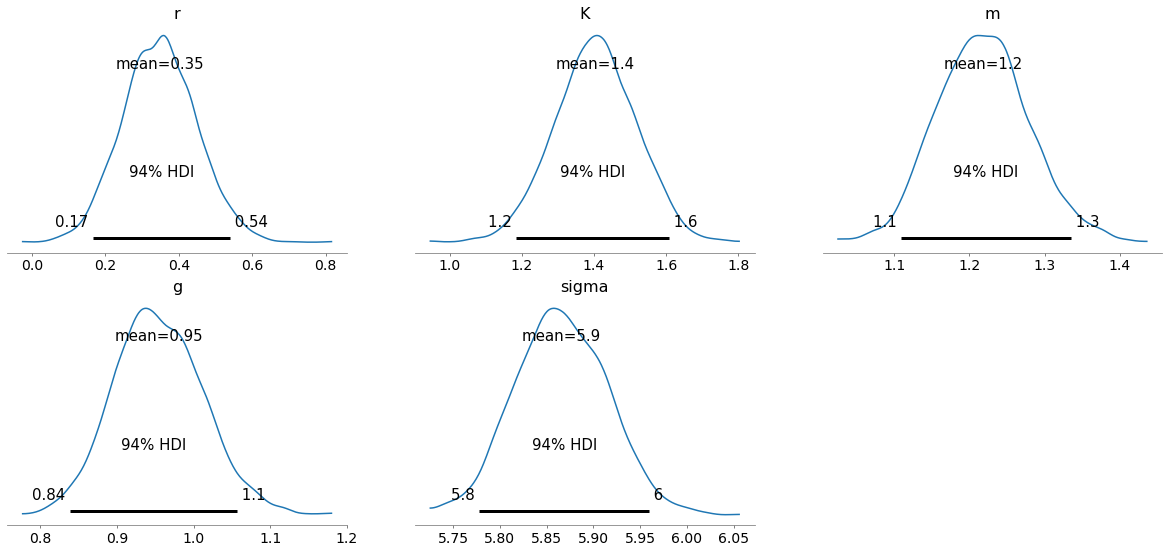

In [81]:
import arviz as az

# Convert the trace to an ArviZ InferenceData object
inference_data = az.from_pymc3(trace)

# Plot the posterior distributions
az.plot_posterior(inference_data)


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


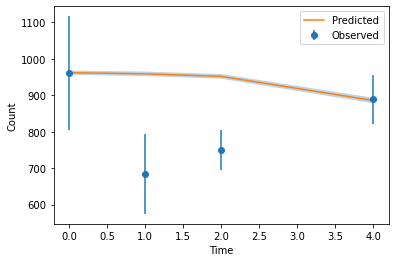

In [104]:
# Define a function that takes parameters and returns expected counts
def compute_expected_counts(params, times):
    r, K, m, g = params['r'], params['K'], params['m'], params['g']
    C0 = grouped_data['mean'].iloc[0]
    expected_counts = [odeint(logistic_decay_model, C0, [0, t], args=(r, K, m, g))[-1][0] for t in times]
    return np.array(expected_counts)

# Sample from the posterior predictive distribution
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=50)

# Compute the mean and standard deviation of the posterior predictive samples
expected_mean = np.mean(ppc['likelihood'], axis=0)
expected_std = np.std(ppc['likelihood'], axis=0)

time_values = grouped_data['Time'].values
mean_values = grouped_data['mean'].values
std_values = grouped_data['std'].values

plt.errorbar(time_values, mean_values, yerr=std_values, fmt='o', label='Observed')
# Plot expected counts
plt.plot(time_values, expected_mean, label='Predicted')
plt.fill_between(grouped_data['Time'], expected_mean - expected_std, expected_mean + expected_std, alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()


# ABC implementation of ODE fitting

# ABC

In [115]:
from pyabc import RV, Distribution
from scipy.integrate import odeint
from pyabc import ABCSMC



In [113]:
# filter df to incldue only Cleaining = NIL and surface == KYDEX
data = df[ (df['Time'] > -.5)]
# Grouping the data by time, surface, and cleaning type and calculating the mean and standard deviation for each group
grouped_data = (
    data.groupby(["Time", "Surface", "Cleaning"])
    .agg(mean=("Count", "mean"), std=("Count", "std"))
    .reset_index()
)

# Displaying the first few rows of the grouped data
print(grouped_data)

    Time          Surface Cleaning         mean         std
0    0.0            KYDEX      ALC  1074.000000  108.629646
1    0.0            KYDEX      CON  1179.000000   46.699036
2    0.0            KYDEX       DW   960.500000  156.469486
3    0.0  Stainless Steel      ALC   109.600000   57.808304
4    0.0  Stainless Steel      CON   295.000000   67.115572
5    0.0  Stainless Steel       DW    33.400000    5.941380
6    1.0            KYDEX      ALC   754.833333   85.630407
7    1.0            KYDEX      CON  1027.166667   44.941814
8    1.0            KYDEX       DW   683.500000  109.260697
9    1.0  Stainless Steel      ALC   102.200000   16.468151
10   1.0  Stainless Steel      CON   135.600000   43.275859
11   1.0  Stainless Steel       DW    20.800000    8.167007
12   2.0            KYDEX      ALC   785.000000  119.042849
13   2.0            KYDEX      CON  1053.166667   21.618665
14   2.0            KYDEX       DW   750.166667   54.027462
15   2.0  Stainless Steel      ALC    36

In [127]:

# Define separate priors for each surface and cleaning regime
from pyabc import RV, Distribution

priors = Distribution(
    KYDEX_r=RV("uniform", 0, 2), 
    KYDEX_K=RV("uniform", 500, 1500),
    KYDEX_m_ALC=RV("uniform", 0, 2),
    KYDEX_g_ALC=RV("uniform", 0, 2),
    KYDEX_m_CON=RV("uniform", 0, 2), # Added
    KYDEX_g_CON=RV("uniform", 0, 2), # Added
    KYDEX_m_DW=RV("uniform", 0, 2),
    KYDEX_g_DW=RV("uniform", 0, 2),
    Stainless_Steel_r=RV("uniform", 0, 2),
    Stainless_Steel_K=RV("uniform", 200, 600),
    Stainless_Steel_m_ALC=RV("uniform", 0, 2),
    Stainless_Steel_g_ALC=RV("uniform", 0, 2),
    Stainless_Steel_m_CON=RV("uniform", 0, 2), # Added
    Stainless_Steel_g_CON=RV("uniform", 0, 2), # Added
    Stainless_Steel_m_DW=RV("uniform", 0, 2),
    Stainless_Steel_g_DW=RV("uniform", 0, 2)
)





def logistic_decay_model(params, times, surface, cleaning):
    r = params[surface + '_r']
    K = params[surface + '_K']
    m = params[surface + '_m_' + cleaning]
    g = params[surface + '_g_' + cleaning]

    # Define the ODE and solve as before
    def dCdt(C, t):
        return r * C * (1 - C / K) - m * np.exp(-g * t) * C

    # Initial condition
    C0 = 1110  # You can adjust this value based on the data

    # Solve the ODE
    C = odeint(dCdt, C0, times)
    return C.flatten()



In [128]:
def distance(simulation, data):
    # Compute the distance for each combination of surface and cleaning regime
    total_distance = 0
    for key in simulation:
        total_distance += np.sum(np.abs(simulation[key] - data[key]))

    return total_distance

# Define the model function
def model(params):
    # Simulate for each combination of surface and cleaning regime
    result = {}
    for surface in ['KYDEX', 'Stainless Steel']:
        for cleaning in ['ALC', 'CON', 'DW']:
            key = f'{surface}_{cleaning}'
            result[key] = logistic_decay_model(params, times, surface, cleaning)
    return result

# Initialize ABCSMC
abc = ABCSMC(model, priors, distance)

# Define a database to store results
db_path = ("sqlite:///abc_results.db")

# Run ABC
abc.new(db_path, grouped_data)
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)


ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=6, start_time=2023-08-08 14:26:25>
ABC INFO: Calibration sample t = -1.
Process Process-105:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 42, in work
    new_sim = simulate_one()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pyabc/inference_util.py", line 109, in simulate_one
    model_result = models[m].summary_statistics(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pyab

ProcessError: At least one worker is dead.

# 3.0 ABC From SCRATCH

In [ ]:

import numpy as np
from scipy.integrate import odeint

In [141]:
### FROM SCRACTH

# filter df to incldue only Cleaining = NIL and surface == KYDEX
data = df[ (df['Time'] > -.5)]
# Grouping the data by time, surface, and cleaning type and calculating the mean and standard deviation for each group
observed_data = (
    data.groupby(["Time", "Surface", "Cleaning"])
    .agg(mean=("Count", "mean"), std=("Count", "std"))
    .reset_index()
)

# Displaying the first few rows of the grouped data
print(observed_data)

    Time          Surface Cleaning         mean         std
0    0.0            KYDEX      ALC  1074.000000  108.629646
1    0.0            KYDEX      CON  1179.000000   46.699036
2    0.0            KYDEX       DW   960.500000  156.469486
3    0.0  Stainless Steel      ALC   109.600000   57.808304
4    0.0  Stainless Steel      CON   295.000000   67.115572
5    0.0  Stainless Steel       DW    33.400000    5.941380
6    1.0            KYDEX      ALC   754.833333   85.630407
7    1.0            KYDEX      CON  1027.166667   44.941814
8    1.0            KYDEX       DW   683.500000  109.260697
9    1.0  Stainless Steel      ALC   102.200000   16.468151
10   1.0  Stainless Steel      CON   135.600000   43.275859
11   1.0  Stainless Steel       DW    20.800000    8.167007
12   2.0            KYDEX      ALC   785.000000  119.042849
13   2.0            KYDEX      CON  1053.166667   21.618665
14   2.0            KYDEX       DW   750.166667   54.027462
15   2.0  Stainless Steel      ALC    36

## 2. Define the Model

In [135]:


def logistic_decay_model(params, times, surface, cleaning):
    surface_key = surface.replace(' ', '_')  # Replace space with underscore
    r = params[surface_key + '_r']
    K = params[surface_key + '_K']
    m = params[surface_key + '_m_' + cleaning]
    g = params[surface_key + '_g_' + cleaning]

    def dCdt(C, t):
        return r * C * (1 - C / K) - m * np.exp(-g * t) * C

    C0 = 1110  # Initial condition
    C = odeint(dCdt, C0, times)
    return C.flatten()


## Priors

In [136]:


def sample_from_prior():
    return {
        'KYDEX_r': np.random.uniform(0, 2),
        'KYDEX_K': np.random.uniform(500, 1500),
        'KYDEX_m_ALC': np.random.uniform(0, 2),
        'KYDEX_g_ALC': np.random.uniform(0, 2),
        'KYDEX_m_CON': np.random.uniform(0, 2),
        'KYDEX_g_CON': np.random.uniform(0, 2),
        'KYDEX_m_DW': np.random.uniform(0, 2),
        'KYDEX_g_DW': np.random.uniform(0, 2),
        'Stainless_Steel_r': np.random.uniform(0, 2),
        'Stainless_Steel_K': np.random.uniform(200, 600),
        'Stainless_Steel_m_ALC': np.random.uniform(0, 2),
        'Stainless_Steel_g_ALC': np.random.uniform(0, 2),
        'Stainless_Steel_m_CON': np.random.uniform(0, 2),
        'Stainless_Steel_g_CON': np.random.uniform(0, 2),
        'Stainless_Steel_m_DW': np.random.uniform(0, 2),
        'Stainless_Steel_g_DW': np.random.uniform(0, 2),
    }



In [137]:
def simulate_model(params, times):
    simulated_data = []
    for surface in ['KYDEX', 'Stainless Steel']:
        for cleaning in ['ALC', 'CON', 'DW']:
            mean_values = logistic_decay_model(params, times, surface, cleaning)
            for time, mean in zip(times, mean_values):
                simulated_data.append((time, surface, cleaning, mean))
    return pd.DataFrame(simulated_data, columns=['Time', 'Surface', 'Cleaning', 'mean'])


## 4. Distance metric

In [161]:
def distance(simulated, observed):
    return np.sum((simulated['mean'] - observed['mean']))


def distance(simulated_data, observed_data):
    # Merge simulated and observed data on common keys (Time, Surface, Cleaning)
    merged_data = pd.merge(simulated_data, observed_data, on=['Time', 'Surface', 'Cleaning'], suffixes=('_sim', '_obs'))
    # Compute squared differences
    squared_diffs = (merged_data['mean_sim'] - merged_data['mean_obs'])**2
    return sum(squared_diffs)


# 5. Run

In [162]:
def abc(observed_data, times, num_samples, epsilon):
    accepted_params = []
    dist=[]
    while len(accepted_params) < num_samples:
        params = sample_from_prior()
        simulated_data = simulate_model(params, times)
        if distance(simulated_data, observed_data) < epsilon:
            accepted_params.append(params)
            #dist.append(distance(simulated_data, observed_data))
    return accepted_params

times = data['Time'].unique()
epsilon = 1000  # You may need to adjust this value
num_samples = 100

accepted_params = abc(observed_data, times, num_samples, epsilon)



In [163]:
# List to store distances
distances = []

# Simulate the model for each set of accepted parameters and compute distances
for params in accepted_params:
    simulated_data = simulate_model(params, times)
    dist = distance(simulated_data, data)
    distances.append((params, dist))

# Sort by distance and select the best 10
best_params = [item[0] for item in sorted(distances, key=lambda x: x[1])[:10]]


KeyError: 'mean'

    Time Surface Cleaning         mean
0    0.0   KYDEX      ALC  1110.000000
1    1.0   KYDEX      ALC   441.383983
2    2.0   KYDEX      ALC   341.879351
3    4.0   KYDEX      ALC   334.161806
4    0.0   KYDEX      CON  1110.000000
5    1.0   KYDEX      CON   181.559410
6    2.0   KYDEX      CON    34.107322
7    4.0   KYDEX      CON     1.680388
8    0.0   KYDEX       DW  1110.000000
9    1.0   KYDEX       DW   529.366779
10   2.0   KYDEX       DW   297.790711
11   4.0   KYDEX       DW   134.274498
    Time Surface Cleaning         mean
0    0.0   KYDEX      ALC  1110.000000
1    1.0   KYDEX      ALC   300.438875
2    2.0   KYDEX      ALC   149.407942
3    4.0   KYDEX      ALC    92.559063
4    0.0   KYDEX      CON  1110.000000
5    1.0   KYDEX      CON   383.491480
6    2.0   KYDEX      CON   284.327334
7    4.0   KYDEX      CON   313.361353
8    0.0   KYDEX       DW  1110.000000
9    1.0   KYDEX       DW   277.285251
10   2.0   KYDEX       DW    88.761242
11   4.0   KYDEX       DW

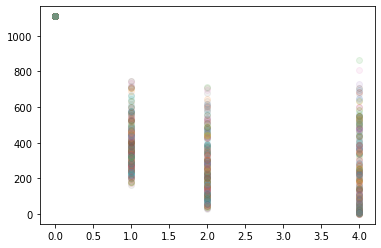

In [156]:
def plot_surface(surface, best_params, observed_data):
    plt.figure(figsize=(12, 8))
    
    # Plot predictions for each cleaning method using the best parameters
    for cleaning in ['ALC', 'CON', 'DW']:
        for params in best_params:
            simulated_data = simulate_model(params, times)
            surface_sim_data = simulated_data[(simulated_data['Surface'] == surface) & (simulated_data['Cleaning'] == cleaning)]
            plt.plot(surface_sim_data['Time'], surface_sim_data['mean'], label=f'Predicted - {cleaning}', alpha=0.5)

        # Plot experimental data
        surface_obs_data = observed_data[(observed_data['Surface'] == surface) & (observed_data['Cleaning'] == cleaning)]
        plt.plot(surface_obs_data['Time'], surface_obs_data['mean'], 'o', label=f'Observed - {cleaning}')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.title(f'{surface} Surface')
    plt.show()

# Plot for 'KYDEX' surface
plot_surface('KYDEX', best_params, data)

# Plot for 'Stainless Steel' surface
plot_surface('Stainless Steel', best_params, data)
